In [ ]:
# get rid of the long sentence in question 2 at dataset (delete all)
# update the numbers at the model


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-10-15 21:42:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-15 21:42:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-15 21:42:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp  drive/My\ Drive/quora-question-pairs.zip quora-question-pairs.zip
!unzip quora-question-pairs.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
import tensorflow as tf
import re
tf.compat.v1.disable_eager_execution()
from nltk.corpus import stopwords
nltk.download("stopwords")
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
file_name="glove.6B.300d.txt"

embeddings_index = {}
with open(file_name) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [11]:
#STOPWORDS = set(stopwords.words('english'))
# data preprocessing
# 1)make text to lower
# 2)remove punctuation
# 3)remove numbers
# 4)remove stopwords
STOPWORDS = set(stopwords.words('english')) 
pattern_stopwords = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b')
pattern_numbers = r'[0-9]'
def dataprocessing(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]', ' ', text)
    text=re.sub(r'”', ' ', text)
    text=re.sub(r'“', ' ', text)
    text=re.sub(r'…', ' ', text)
    text=re.sub(r'’', ' ', text)
    text=re.sub(r'‘', ' ', text)
    text = re.sub(pattern_numbers, ' ', text)
    return re.sub(pattern_stopwords,' ',text)
def apply_preprocessing(data:pd.DataFrame):
  data["question1"] = data["question1"].astype(str)
  data["question2"] = data["question2"].astype(str)
  data["question1"] = data["question1"].apply(lambda text: dataprocessing(text))
  data["question2"] = data["question2"].apply(lambda text: dataprocessing(text))
  return data

  

In [ ]:
def get_input(data:pd.DataFrame):
  word_tokenizer = Tokenizer()
  data["count_1"] =  [len(text) for text in data["question1"]]
  data["count_2"] =  [len(text) for text in data["question2"]]
  data_filtered_1 = data[data['count_2']<=75]
  tf2 = data_filtered_1[data_filtered_1['count_1']<=75]
  word_tokenizer.fit_on_texts(data["question1"]+data["question2"])
  vocab_length = len(word_tokenizer.word_index) + 1
  dic=word_tokenizer.word_index
  tf2["embedded_sentences_1"] = word_tokenizer.texts_to_sequences(tf2["question1"])
  tf2["embedded_sentences_2"] = word_tokenizer.texts_to_sequences(tf2["question2"])
  emb_pad_1 = pad_sequences(tf2["embedded_sentences_1"],15, padding='post')
  emb_pad_2 = pad_sequences(tf2["embedded_sentences_2"],15, padding='post')
  return dic,vocab_length,emb_pad_1,emb_pad_2,tf2 

In [ ]:
'''data = pd.read_csv('train.csv')
train = apply_preprocessing(data)
train = train.sample(frac = 1)
train_portion=int(0.9*train.shape[0])
train_X = train[0:train_portion]
word_tokenizer = Tokenizer()
data["count_1"] =  [len(text) for text in data["question1"]]
data["count_2"] =  [len(text) for text in data["question2"]]
data_filtered_1 = data[data['count_2']<=75]
tf2 = data_filtered_1[data_filtered_1['count_1']<=75]
word_tokenizer.fit_on_texts(data["question1"]+data["question2"])
vocab_length = len(word_tokenizer.word_index) + 1
dic=word_tokenizer.word_index
tf2["embedded_sentences_1"] = word_tokenizer.texts_to_sequences(tf2["question1"])
tf2["embedded_sentences_2"] = word_tokenizer.texts_to_sequences(tf2["question2"])
tf2["count_1"] =  [len(text) for text in tf2["embedded_sentences_1"]]
tf2["count_2"] =  [len(text) for text in tf2["embedded_sentences_2"]]
'''

'data = pd.read_csv(\'train.csv\')\ntrain = apply_preprocessing(data)\ntrain = train.sample(frac = 1)\ntrain_portion=int(0.9*train.shape[0])\ntrain_X = train[0:train_portion]\nword_tokenizer = Tokenizer()\ndata["count_1"] =  [len(text) for text in data["question1"]]\ndata["count_2"] =  [len(text) for text in data["question2"]]\ndata_filtered_1 = data[data[\'count_2\']<=75]\ntf2 = data_filtered_1[data_filtered_1[\'count_1\']<=75]\nword_tokenizer.fit_on_texts(data["question1"]+data["question2"])\nvocab_length = len(word_tokenizer.word_index) + 1\ndic=word_tokenizer.word_index\ntf2["embedded_sentences_1"] = word_tokenizer.texts_to_sequences(tf2["question1"])\ntf2["embedded_sentences_2"] = word_tokenizer.texts_to_sequences(tf2["question2"])\ntf2["count_1"] =  [len(text) for text in tf2["embedded_sentences_1"]]\ntf2["count_2"] =  [len(text) for text in tf2["embedded_sentences_2"]]\n'

In [ ]:
data = pd.read_csv('train.csv')
train = apply_preprocessing(data)
train = train.sample(frac = 1)
train_portion=int(0.35*train.shape[0])
val_portion=int(0.05*train.shape[0])
test_portion=int(0.05*train.shape[0])
pos1=train_portion + val_portion
last_pos=pos1 + test_portion
train_X = train[0:train_portion]
val_X = train[train_portion:pos1]
test_X = train[pos1:last_pos]
dic,vocab_length,train_emb_pad_1,train_emb_pad_2,train_tf2 = get_input(train_X)
_,_,test_emb_pad_1,test_emb_pad_2,test_tf2 = get_input(test_X)
_,_,val_emb_pad_1,val_emb_pad_2,val_tf2 = get_input(val_X)

(141501, 8)


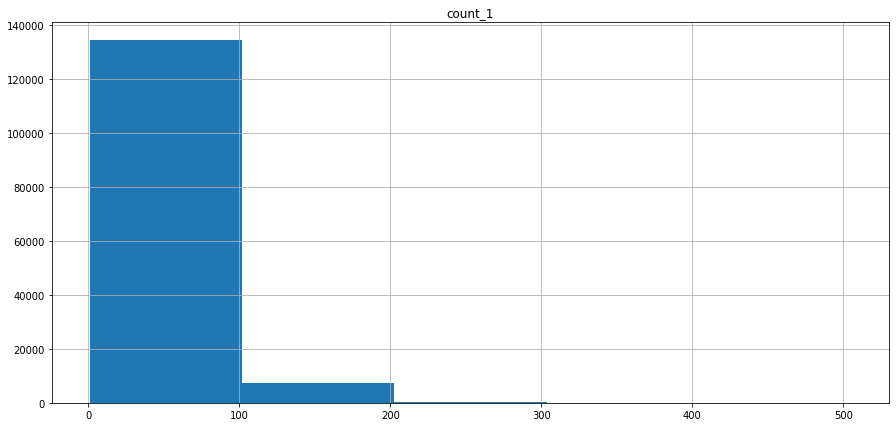

In [13]:
print(train_X.shape)
train_X.hist(column=["count_1"],figsize=[15,7],bins=5)
plt.show()

In [14]:
m = train_tf2.shape[0]
print(m)

110913


In [15]:
num_tokens = len(dic) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in dic.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        #print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(num_tokens)

Converted 41072 words (9565 misses)
50639


In [16]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [20]:
input1 = tf.keras.Input(shape =(15,),name="input1")
input2 = tf.keras.Input(shape =(15,),name="input2")
X1 = embedding_layer(input1)
X2 = embedding_layer(input2)
X1 = layers.LSTM(128,return_sequences=True)(X1)
X1 = layers.LSTM(128,)(X1)
X2 = layers.LSTM(128,return_sequences=True)(X2)
X2 = layers.LSTM(128)(X2)
X =  layers.Concatenate(axis=1)([X1, X2])
output = layers.Dense(1, activation='sigmoid')(X) 
model = Model(inputs=[input1,input2],outputs=output)

In [21]:
#opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['acc'])
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 15)]         0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             15191700    input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 15, 128)      219648      embedding[2][0]       

In [ ]:
print(train_emb_pad_1[0])

In [22]:
model.fit([train_emb_pad_1,train_emb_pad_2], train_tf2["is_duplicate"],batch_size =128, epochs=5, verbose=1,validation_data=[[val_emb_pad_1,val_emb_pad_2],val_tf2["is_duplicate"]])


Train on 110913 samples, validate on 15809 samples
Epoch 1/5
110913/110913 [==============================] - ETA: 0s - loss: 0.2117 - acc: 0.6687WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
110913/110913 [==============================] - 209s 2ms/sample - loss: 0.2117 - acc: 0.6687 - val_loss: 0.2497 - val_acc: 0.5920
Epoch 2/5
110913/110913 [==============================] - 206s 2ms/sample - loss: 0.1930 - acc: 0.7063 - val_loss: 0.2544 - val_acc: 0.5934
Epoch 3/5
110913/110913 [==============================] - 209s 2ms/sample - loss: 0.1802 - acc: 0.7313 - val_loss: 0.2529 - val_acc: 0.5876
Epoch 4/5
110913/110913 [==============================] - 211s 2ms/sample - loss: 0.16

In [23]:
loss, accuracy = model.evaluate([test_emb_pad_1,test_emb_pad_2],test_tf2["is_duplicate"], verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % loss)

Accuracy: 58.843172
loss: 0.268061


**Pretrained model**

In [ ]:
#supports two segmentation algorithms, byte-pair-encoding (BPE)and unigram language model
! pip install sentencepiece

In [ ]:
! wget https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip
! unzip cased_L-12_H-768_A-12.zip

In [ ]:
! git clone https://github.com/zihangdai/xlnet.git

In [ ]:
SCRIPTS_DIR = 'xlnet' #@param {type:"string"}
DATA_DIR = 'train.csv' #@param {type:"string"}
OUTPUT_DIR = 'proc_data/quora' #@param {type:"string"}
PRETRAINED_MODEL_DIR = 'xlnet_cased_L-12_H-768_A-12' #@param {type:"string"}
CHECKPOINT_DIR = 'exp/quora' #@param {type:"string"}

In [ ]:
train_command = "python xlnet/run_classifier.py \
  --do_train=True \
  --do_eval=True \
  --eval_all_ckpt=True \
  --task_name=quora \
  --data_dir="+DATA_DIR+" \
  --output_dir="+OUTPUT_DIR+" \
  --model_dir="+CHECKPOINT_DIR+" \
  --uncased=False \
  --spiece_model_file="+PRETRAINED_MODEL_DIR+"/spiece.model \
  --model_config_path="+PRETRAINED_MODEL_DIR+"/xlnet_config.json \
  --init_checkpoint="+PRETRAINED_MODEL_DIR+"/xlnet_model.ckpt \
  --max_seq_length=128 \
  --train_batch_size=8 \
  --eval_batch_size=8 \
  --num_hosts=1 \
  --num_core_per_host=1 \
  --learning_rate=2e-5 \
  --train_steps=4000 \
  --warmup_steps=500 \
  --save_steps=500 \
  --iterations=500"

! {train_command}